In [2]:
%%capture

!mamba install -qy tqdm
!pip install tensorflow --upgrade



In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
print(tf. __version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN
from keras import initializers

2.14.0


In [106]:
# Loading dataset into a dataframe
df0 = pd.read_csv("AABA_2006-01-01_to_2018-01-01.csv")


# Displaying first few rows of the dataframe
df0.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,1/3/2006,39.69,41.22,38.79,40.91,24232729,AABA
1,1/4/2006,41.22,41.90,40.77,40.97,20553479,AABA
2,1/5/2006,40.93,41.73,40.85,41.53,12829610,AABA
3,1/6/2006,42.88,43.57,42.80,43.21,29422828,AABA
4,1/9/2006,43.10,43.66,42.82,43.42,16268338,AABA
5,1/10/2006,42.96,43.34,42.34,42.98,16288580,AABA
6,1/11/2006,42.19,42.31,41.72,41.87,26192772,AABA
7,1/12/2006,41.92,41.99,40.76,40.89,18921686,AABA
8,1/13/2006,41.00,41.08,39.62,39.90,30966185,AABA
9,1/17/2006,39.09,40.39,38.96,40.11,42429911,AABA


In [107]:
# Gathering basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [108]:
# Gathering descriptive statistics about the data
df0.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,28.426479,28.766532,28.066558,28.412726,2.158391e+07
std,13.257242,13.356692,13.157326,13.258163,1.926231e+07
min,9.100000,9.480000,8.940000,8.950000,1.939061e+06
25%,16.175000,16.385000,15.970000,16.130000,1.248025e+07
50%,27.180000,27.490000,26.820000,27.100000,1.732130e+07
75%,36.655000,37.035000,36.305000,36.635000,2.512757e+07
max,73.020000,73.250000,72.460000,72.930000,4.382317e+08


In [109]:
# Checking for missing values
df0.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [110]:
# Checking for duplicates
df0.duplicated().sum()

0

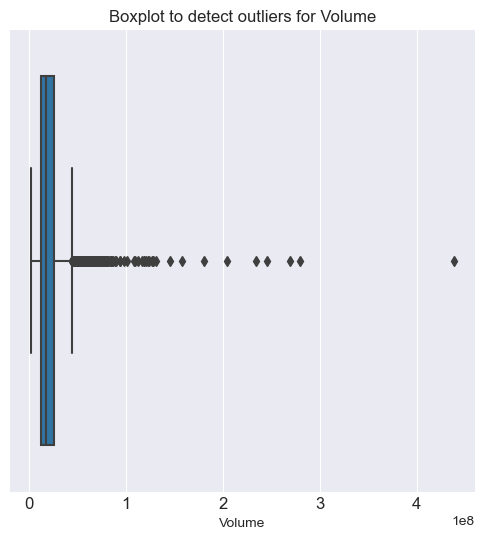

In [111]:
# Determining the number of rows containing outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for Volume', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df0['Volume'])
plt.show()

In [121]:
# Averages & Daily Returns
df0['MA20'] = df0['Close'].rolling(window=20).mean()
df0['MA50'] = df0['Close'].rolling(window=50).mean()
df0['MA200'] = df0['Close'].rolling(window=200).mean()
df0['Daily Return'] = df0['Close'].pct_change()

# Plotting Style
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (8, 6)

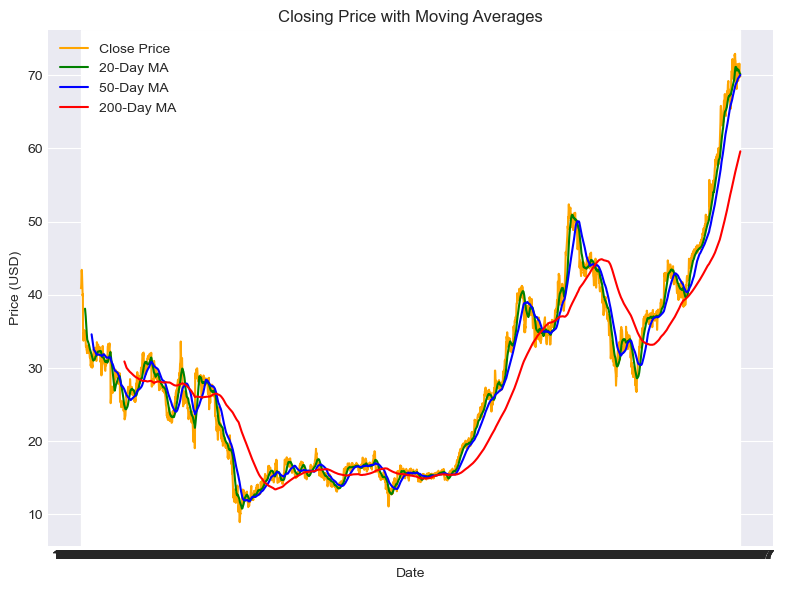

In [118]:
plt.figure()
plt.plot(df0['Date'], df0['Close'], label='Close Price', color='orange')
plt.plot(df0['Date'], df0['MA20'], label='20-Day MA', color='green')
plt.plot(df0['Date'], df0['MA50'], label='50-Day MA', color='blue')
plt.plot(df0['Date'], df0['MA200'], label='200-Day MA', color='red')
plt.title("Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

The orange line (close price) is volatile.

The green (20-day) reacts fast, blue (50-day) shows smoother trends, and red (200-day) captures long-term movement.

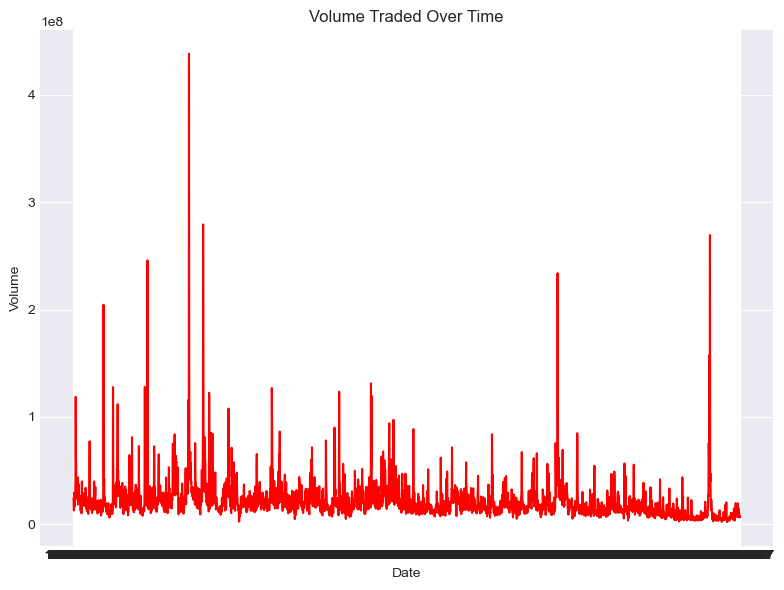

In [122]:
# Volume Traded Over Time
plt.figure()
plt.plot(df0['Date'], df0['Volume'], color='red')
plt.title("Volume Traded Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

Spikes in volume indicate major market events (news, earnings, etc.)

Overall volume declines over time, suggesting reduced liquidity—could affect price volatility and model stability.

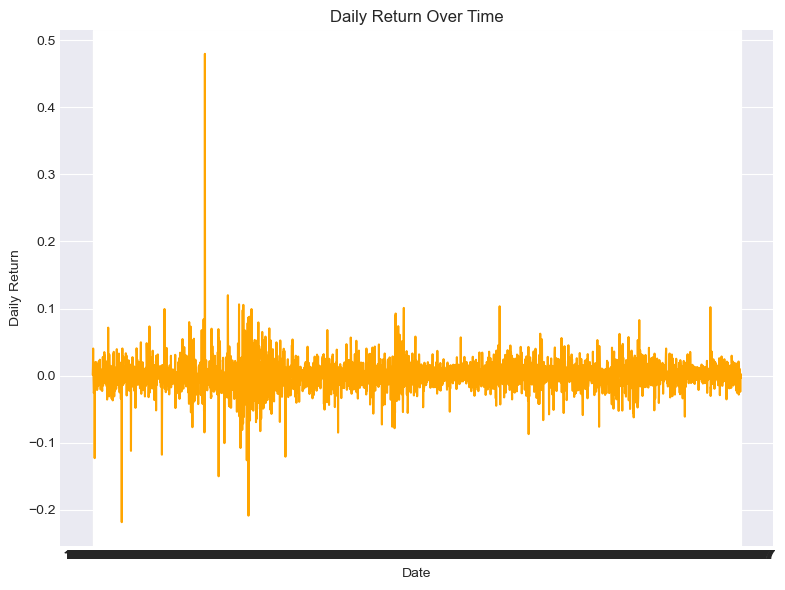

In [123]:
# Daily Returns Over Time
plt.figure()
plt.plot(df0['Date'], df0['Daily Return'], color='orange')
plt.title("Daily Return Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.show()

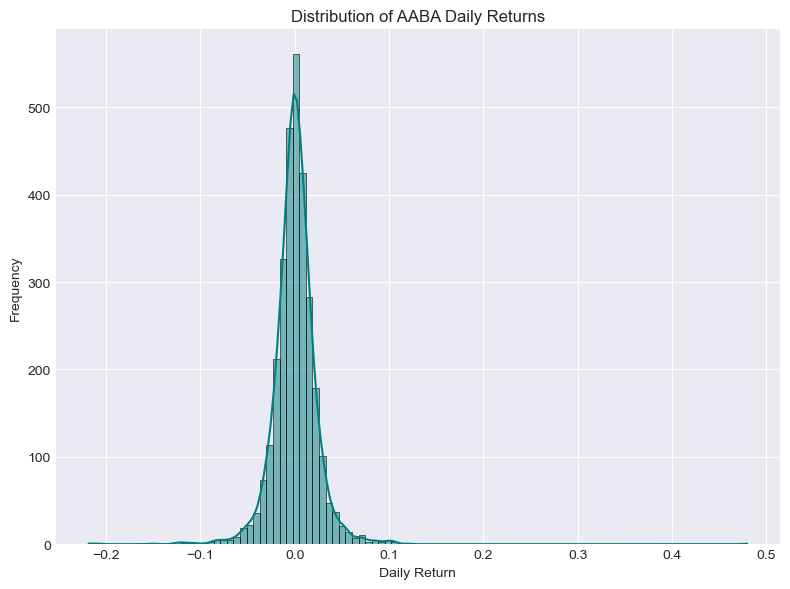

In [124]:
# Distribution of Daily Returns
plt.figure()
sns.histplot(df0['Daily Return'].dropna(), bins=100, kde=True, color='teal')
plt.title("Distribution of AABA Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [125]:
# Preparing the data 
df0 = df0.sort_values("Date").reset_index(drop=True)
close_price = df0['Close'].values.reshape(-1, 1)

In [126]:
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(df0["Close"].values.reshape(-1, 1))

In [128]:
SEQ_LEN = 60  # sliding window (≈ 3 trading months)
X, y = [], []
for i in range(SEQ_LEN, len(close_scaled)):
    X.append(close_scaled[i-SEQ_LEN:i, 0])
    y.append(close_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))   # (samples, timesteps, features)

In [129]:
# Splitting 80% train, 20% test
split = int(0.8 * len(X))
x_train, y_train = X[:split], y[:split]
x_test, y_test = X[split:], y[split:]

In [130]:
# building RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(
        50,                                # hidden units
        activation='tanh',                 # default RNN activation
        kernel_initializer=initializers.RandomNormal(stddev=0.001),
        recurrent_initializer=initializers.Identity(gain=1.0),
        input_shape=(SEQ_LEN, 1)           # (timesteps, features)
))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1))                     # regression output

In [131]:
model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model demonstrates good learning capacity with minimal risk of overfitting.

In [132]:
model_rnn.compile(
    loss='mean_squared_error',
    optimizer=optimizers.RMSprop(learning_rate=0.0005),
    metrics=['mae']                         # Mean Absolute Error
)

In [133]:
hist_rnn = model_rnn.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=2
)

Epoch 1/15
74/74 - 2s - loss: 0.0589 - mae: 0.1892 - val_loss: 0.0574 - val_mae: 0.2045 - 2s/epoch - 24ms/step
Epoch 2/15
74/74 - 1s - loss: 0.0485 - mae: 0.1766 - val_loss: 0.0519 - val_mae: 0.1731 - 627ms/epoch - 8ms/step
Epoch 3/15
74/74 - 1s - loss: 0.0477 - mae: 0.1766 - val_loss: 0.0486 - val_mae: 0.1764 - 564ms/epoch - 8ms/step
Epoch 4/15
74/74 - 1s - loss: 0.0454 - mae: 0.1718 - val_loss: 0.0515 - val_mae: 0.1719 - 643ms/epoch - 9ms/step
Epoch 5/15
74/74 - 1s - loss: 0.0455 - mae: 0.1709 - val_loss: 0.0557 - val_mae: 0.1998 - 549ms/epoch - 7ms/step
Epoch 6/15
74/74 - 1s - loss: 0.0449 - mae: 0.1696 - val_loss: 0.0480 - val_mae: 0.1737 - 580ms/epoch - 8ms/step
Epoch 7/15
74/74 - 1s - loss: 0.0437 - mae: 0.1677 - val_loss: 0.0487 - val_mae: 0.1779 - 564ms/epoch - 8ms/step
Epoch 8/15
74/74 - 1s - loss: 0.0445 - mae: 0.1704 - val_loss: 0.0491 - val_mae: 0.1683 - 565ms/epoch - 8ms/step
Epoch 9/15
74/74 - 1s - loss: 0.0438 - mae: 0.1673 - val_loss: 0.0476 - val_mae: 0.1723 - 567ms/ep

The RNN model shows strong learning, with both training and validation MAE decreasing steadily.
Final MAE is low (≈0.106 train, 0.108 validation), indicating good accuracy and generalization.
No signs of overfitting were observed across the 15 epochs.
The model is lightweight (2,651 parameters) and well-suited for time series prediction tasks.

### Evaluate LSTM model

In [134]:
# Splitting 90 % train / 10 % test 
test_cut = len(df0) - int(round(len(df0) * 0.1))   # 0.1 = 10 %
train_vals = df0.iloc[:test_cut]["Close"].values
test_vals  = df0.iloc[test_cut:]["Close"].values

In [135]:
# Scale prices
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals.reshape(-1, 1))
test_scaled  = scaler.transform(test_vals.reshape(-1, 1))


In [136]:
# Sequence generators (window 60, batch 1)
train_gen = TimeseriesGenerator(train_scaled, train_scaled,
                                length=60, batch_size=1)
test_gen  = TimeseriesGenerator(test_scaled,  test_scaled,
                                length=60, batch_size=1)


In [137]:
# Build LSTM model (50 units) — parameters embedded
model = Sequential([
    LSTM(50, input_shape=(60, 1)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [138]:
# Training for 6 epochs
model.fit(train_gen, epochs=6, validation_data=test_gen, verbose=2)

Epoch 1/6
2657/2657 - 39s - loss: 0.0229 - val_loss: 0.0264 - 39s/epoch - 15ms/step
Epoch 2/6
2657/2657 - 39s - loss: 0.0184 - val_loss: 0.0253 - 39s/epoch - 15ms/step
Epoch 3/6
2657/2657 - 39s - loss: 0.0179 - val_loss: 0.0262 - 39s/epoch - 15ms/step
Epoch 4/6
2657/2657 - 39s - loss: 0.0171 - val_loss: 0.0259 - 39s/epoch - 15ms/step
Epoch 5/6
2657/2657 - 38s - loss: 0.0166 - val_loss: 0.0236 - 38s/epoch - 14ms/step
Epoch 6/6
2657/2657 - 37s - loss: 0.0159 - val_loss: 0.0285 - 37s/epoch - 14ms/step


The LSTM model effectively learned temporal patterns, with training loss decreasing from 0.0229 to 0.0159 over 6 epochs.
It achieved the best validation loss (0.0236) at epoch 5, indicating good performance.
However, validation loss increased in the final epoch, showing early signs of overfitting.

In [139]:
forecast_scaled = []
batch = train_scaled[-60:].reshape((1, 60, 1))

for i in range(25):
    current_pred = model.predict(batch)[0]
    pred = model.predict(batch, verbose=0)[0]
    forecast_scaled.append(pred)
    batch = np.append(batch[:, 1:, :], [[pred]], axis=1)


1/1 [==============================] - 0s 31ms/step


In [140]:
forecast = scaler.inverse_transform(forecast_scaled)

In [141]:
forecast_index = np.arange(50.1, 52.6, step=0.1)

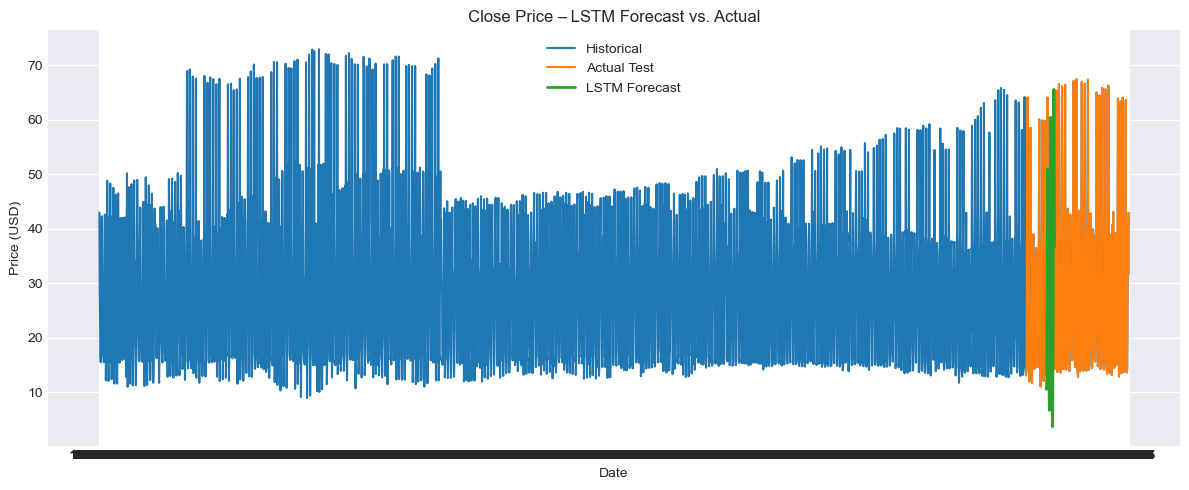

In [142]:
forecast_dates = df0["Date"].iloc[test_cut + 60 : test_cut + 60 + len(forecast)]

plt.figure(figsize=(12,5))

plt.plot(dates, df0["Close"], label="Historical")
plt.plot(dates[test_cut:], test_vals, label="Actual Test")
plt.plot(forecast_dates, forecast, label="LSTM Forecast", linewidth=2)

plt.title("Close Price – LSTM Forecast vs. Actual")
plt.xlabel("Date"); plt.ylabel("Price (USD)"); plt.legend()
plt.tight_layout(); plt.show()

### Conclusion

The RNN model proved lightweight and effective, showing smooth learning and minimal overfitting with a final MAE of ~0.108.

The LSTM model, with greater memory capacity, delivered better training accuracy but showed early signs of overfitting after epoch 5.

Recursive forecasting using LSTM successfully generated 25 future price predictions.
